# Preprocessing notebook for ProcSys Project

### Step 0: Evaluate correlation matrix for raw data

C:\Users\a69h3zz\AppData\Local\Temp\7\ipykernel_6776\951855591.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr().abs()


<Axes: >

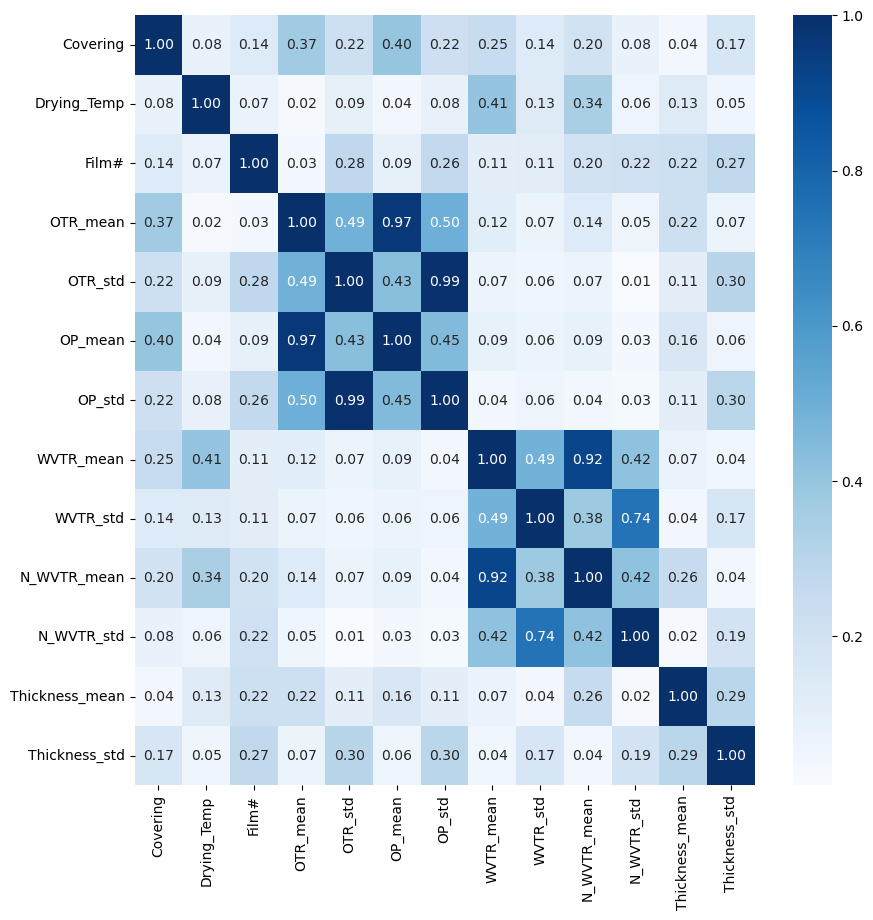

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
data = pd.read_csv('Aggregated_Data_RH50.csv')
# Generatea and plot the correlation matrix for data
corr = data.corr().abs()
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
sns.heatmap(corr,ax = ax, cmap='Blues', annot=True, fmt='.2f')

In [3]:
print(data.columns)
print(data.head())

Index(['Name', 'Covering', 'Drying_Temp', 'Mold_Substrate', 'Film#',
       'OTR_mean', 'OTR_std', 'OP_mean', 'OP_std', 'WVTR_mean', 'WVTR_std',
       'N_WVTR_mean', 'N_WVTR_std', 'Thickness_mean', 'Thickness_std'],
      dtype='object')
                    Name  Covering  Drying_Temp Mold_Substrate  Film#  \
0        1:1 CNC/ChNC-CS       0.0         23.0             ps      1   
1        1:1 CNC/ChNF-CP       0.0         23.0             ps      2   
2        1:1 CNC/ChNF-CP       1.0         23.0          glass      1   
3  1:1 CNC/ChNF-CP-100-3       1.0         23.0          glass      2   
4      1:1 CNC/ChNF-CP-2       1.0         23.0          glass      2   

   OTR_mean  OTR_std  OP_mean  OP_std  WVTR_mean  WVTR_std  N_WVTR_mean  \
0     23.30     0.00    11.00    0.00     3430.0      0.00       160.00   
1     45.50     0.00    14.00    0.00     5760.0      0.00       190.00   
2     21.67     4.06     8.15    1.35     9740.0   1093.43       366.67   
3     11.81     3.29  

### Step 1: Handle numerical data stored as strings and categorical data via conversion to fractions and one-hot encoding

- Find the rows that contain slashes: indicative of multiple components

In [4]:
def find_row_indices_with_slash(x):
    if '/' in x:
        return True
    else:
        return False
    
# example usage 
slash_rows = data['Name'].apply(find_row_indices_with_slash)
no_slash_rows = [not slash_rows[i] for i in range(len(slash_rows))]
slash_data, no_slash_data = data.loc[slash_rows,:], data.loc[no_slash_rows,:]

- The data is split into two parts, one with '/' in the name and the other without '/' in the name. Evaluate overlap and unique elements

In [5]:
from itertools import chain

def split_strings_with_slash(x):
    try:
        temp = x.split(' ')[1]
    except IndexError:
        temp = x
    temp_split = temp.split('/')
    return temp_split

_split = slash_data['Name'].apply(split_strings_with_slash).to_numpy()

_all = list(chain.from_iterable((_split[i]) for i in range(len(_split))))

_set_all_slash = set(_all)
_set_noslash = set(no_slash_data['Name'])

unique_slash = _set_all_slash - _set_noslash
unique_noslash = _set_noslash - _set_all_slash
common = _set_noslash & _set_all_slash

print('Unique multi-component: ', unique_slash, '\nUnique single component: ', unique_noslash, '\nCommon: ', common)

Unique multi-component:  {'20CA', 'PLA-3L', '30CA', 'ChNF-L-UH', '100CA', '10CA', 'ChNC-CS', 'PLA-15L', 'Ca-120-3', 'ChNF-Sugino', '30CA-120-3', 'Ca-150-3', 'ChNF-M-120-3', 'Al', 'Ca-1-20', 'PLA-6L-120-3', 'ChNF-L-120-3', '20CA-120-3', 'ChNF-CP-2-100-3', 'PLA-6L', 'ChNF-M-150-3', '50CA', 'Ca'} 
Unique single component:  {'TOCN-COONa', 'TOCN-COOCa', 'ChNC-CP', 'Earthfirst PLA'} 
Common:  {'CNC', 'ChNF-H', 'ChNF-CP-100-3', 'ChNF-CP-2', 'ChNF-M', 'ChNF-CS', 'ChNF-CP', 'Chitosan', 'ChNF-EL', 'PLA', 'ChNF-L'}


- Convert information from 'Name' column to numerica data. Create fractions based on component ratio and one hot encode variables for which there is not ratio information

In [6]:
num_new_columns = len(unique_slash) + len(unique_noslash) + len(common)
print('Number of new columns: ', num_new_columns)

new_col_values = {_key:[] for _key in list(unique_slash)+list(unique_noslash)+list(common)}

def get_new_column_vals(x):
    temp = x.split(' ')
    # Need to fill dictionary new_col_values with the fractional values of the first two components of comps and with one hot encoding for the third component
    if len(temp) == 1:
        # No space
        comp = temp[0].split('/')
        if len(comp) == 1:
            new_col_values[temp[0]].append(1)
            for key in new_col_values.keys():
                if key != temp[0]:
                    new_col_values[key].append(0)
        else:
            for key in new_col_values.keys():
                if key == comp[0]:
                    new_col_values[key].append(1)
                elif key == comp[1]:
                    new_col_values[key].append(1)
                else:
                    new_col_values[key].append(0)
    elif len(temp) == 2:
        # One slash
        #Handle outlier case
        if temp[0] == 'Earthfirst':
            new_col_values['Earthfirst PLA'].append(1)
            for key in new_col_values.keys():
                if key != 'Earthfirst PLA':
                    new_col_values[key].append(0)
        else:
            ratio, comps = temp[0].split(':'), temp[1].split('/')
            _num1, _num2 = float(ratio[0]), float(ratio[1])
            _frac1, _frac2 = _num1/(_num1+_num2), _num2/(_num1+_num2)
            for key in new_col_values.keys():
                if key == comps[0]:
                    new_col_values[key].append(_frac1)
                elif key == comps[1]:
                    new_col_values[key].append(_frac2)
                else:
                    new_col_values[key].append(0)
    elif len(temp) == 3:
        # Two slashes
        ratio, comps = temp[0].split(':'), temp[1].split('/')
        _num1, _num2 = float(ratio[0]), float(ratio[1])
        _frac1, _frac2 = _num1/(_num1+_num2), _num2/(_num1+_num2)
        for key in new_col_values.keys():
            if key == comps[0]:
                new_col_values[key].append(_frac1)
            elif key == comps[1]:
                new_col_values[key].append(_frac2)
            elif key == temp[2]:
                new_col_values[key].append(1)
            else:
                new_col_values[key].append(0)

    return None

data['Name'].apply(get_new_column_vals)

new_data = pd.DataFrame(new_col_values)
print(new_data.head())

Number of new columns:  38
   20CA  PLA-3L  30CA  ChNF-L-UH  100CA  10CA  ChNC-CS  PLA-15L  Ca-120-3  \
0     0       0     0        0.0      0     0      0.5        0         0   
1     0       0     0        0.0      0     0      0.0        0         0   
2     0       0     0        0.0      0     0      0.0        0         0   
3     0       0     0        0.0      0     0      0.0        0         0   
4     0       0     0        0.0      0     0      0.0        0         0   

   ChNF-Sugino  ...  ChNF-H  ChNF-CP-100-3  ChNF-CP-2  ChNF-M  ChNF-CS  \
0          0.0  ...     0.0            0.0        0.0     0.0      0.0   
1          0.0  ...     0.0            0.0        0.0     0.0      0.0   
2          0.0  ...     0.0            0.0        0.0     0.0      0.0   
3          0.0  ...     0.0            0.5        0.0     0.0      0.0   
4          0.0  ...     0.0            0.0        0.5     0.0      0.0   

   ChNF-CP  Chitosan  ChNF-EL  PLA  ChNF-L  
0      0.0       0.0

- One hot encode the categorical variables correponsind to substrate

In [7]:
df_Mold_Substrate_onehot = pd.get_dummies(data['Mold_Substrate'])
df_Mold_Substrate_onehot.rename(columns={'PLA':'PLA_substrate'}, inplace=True)
print(df_Mold_Substrate_onehot.head())

   PLA_substrate  glass  none  ps  ptfe
0              0      0     0   1     0
1              0      0     0   1     0
2              0      1     0   0     0
3              0      1     0   0     0
4              0      1     0   0     0


- Add transformed variables into dataset and save result

In [8]:
columns = [i for i in data.columns if i not in ['Name', 'Mold_Substrate']]
df = pd.concat([data[columns], new_data, df_Mold_Substrate_onehot], axis=1)
df.head()
df.to_csv('Preprocessed_Data_RH50.csv')

In [9]:
df = pd.read_csv('Preprocessed_Data_RH50.csv', index_col=0, header=0, delimiter=',')

- Replot correlation matrix. Note, seems like strongest relevant correlations between input and output properties are for thickness and material compositions at least in terms of positive correlations. Lots of negative correlations implying inverse relationships. 

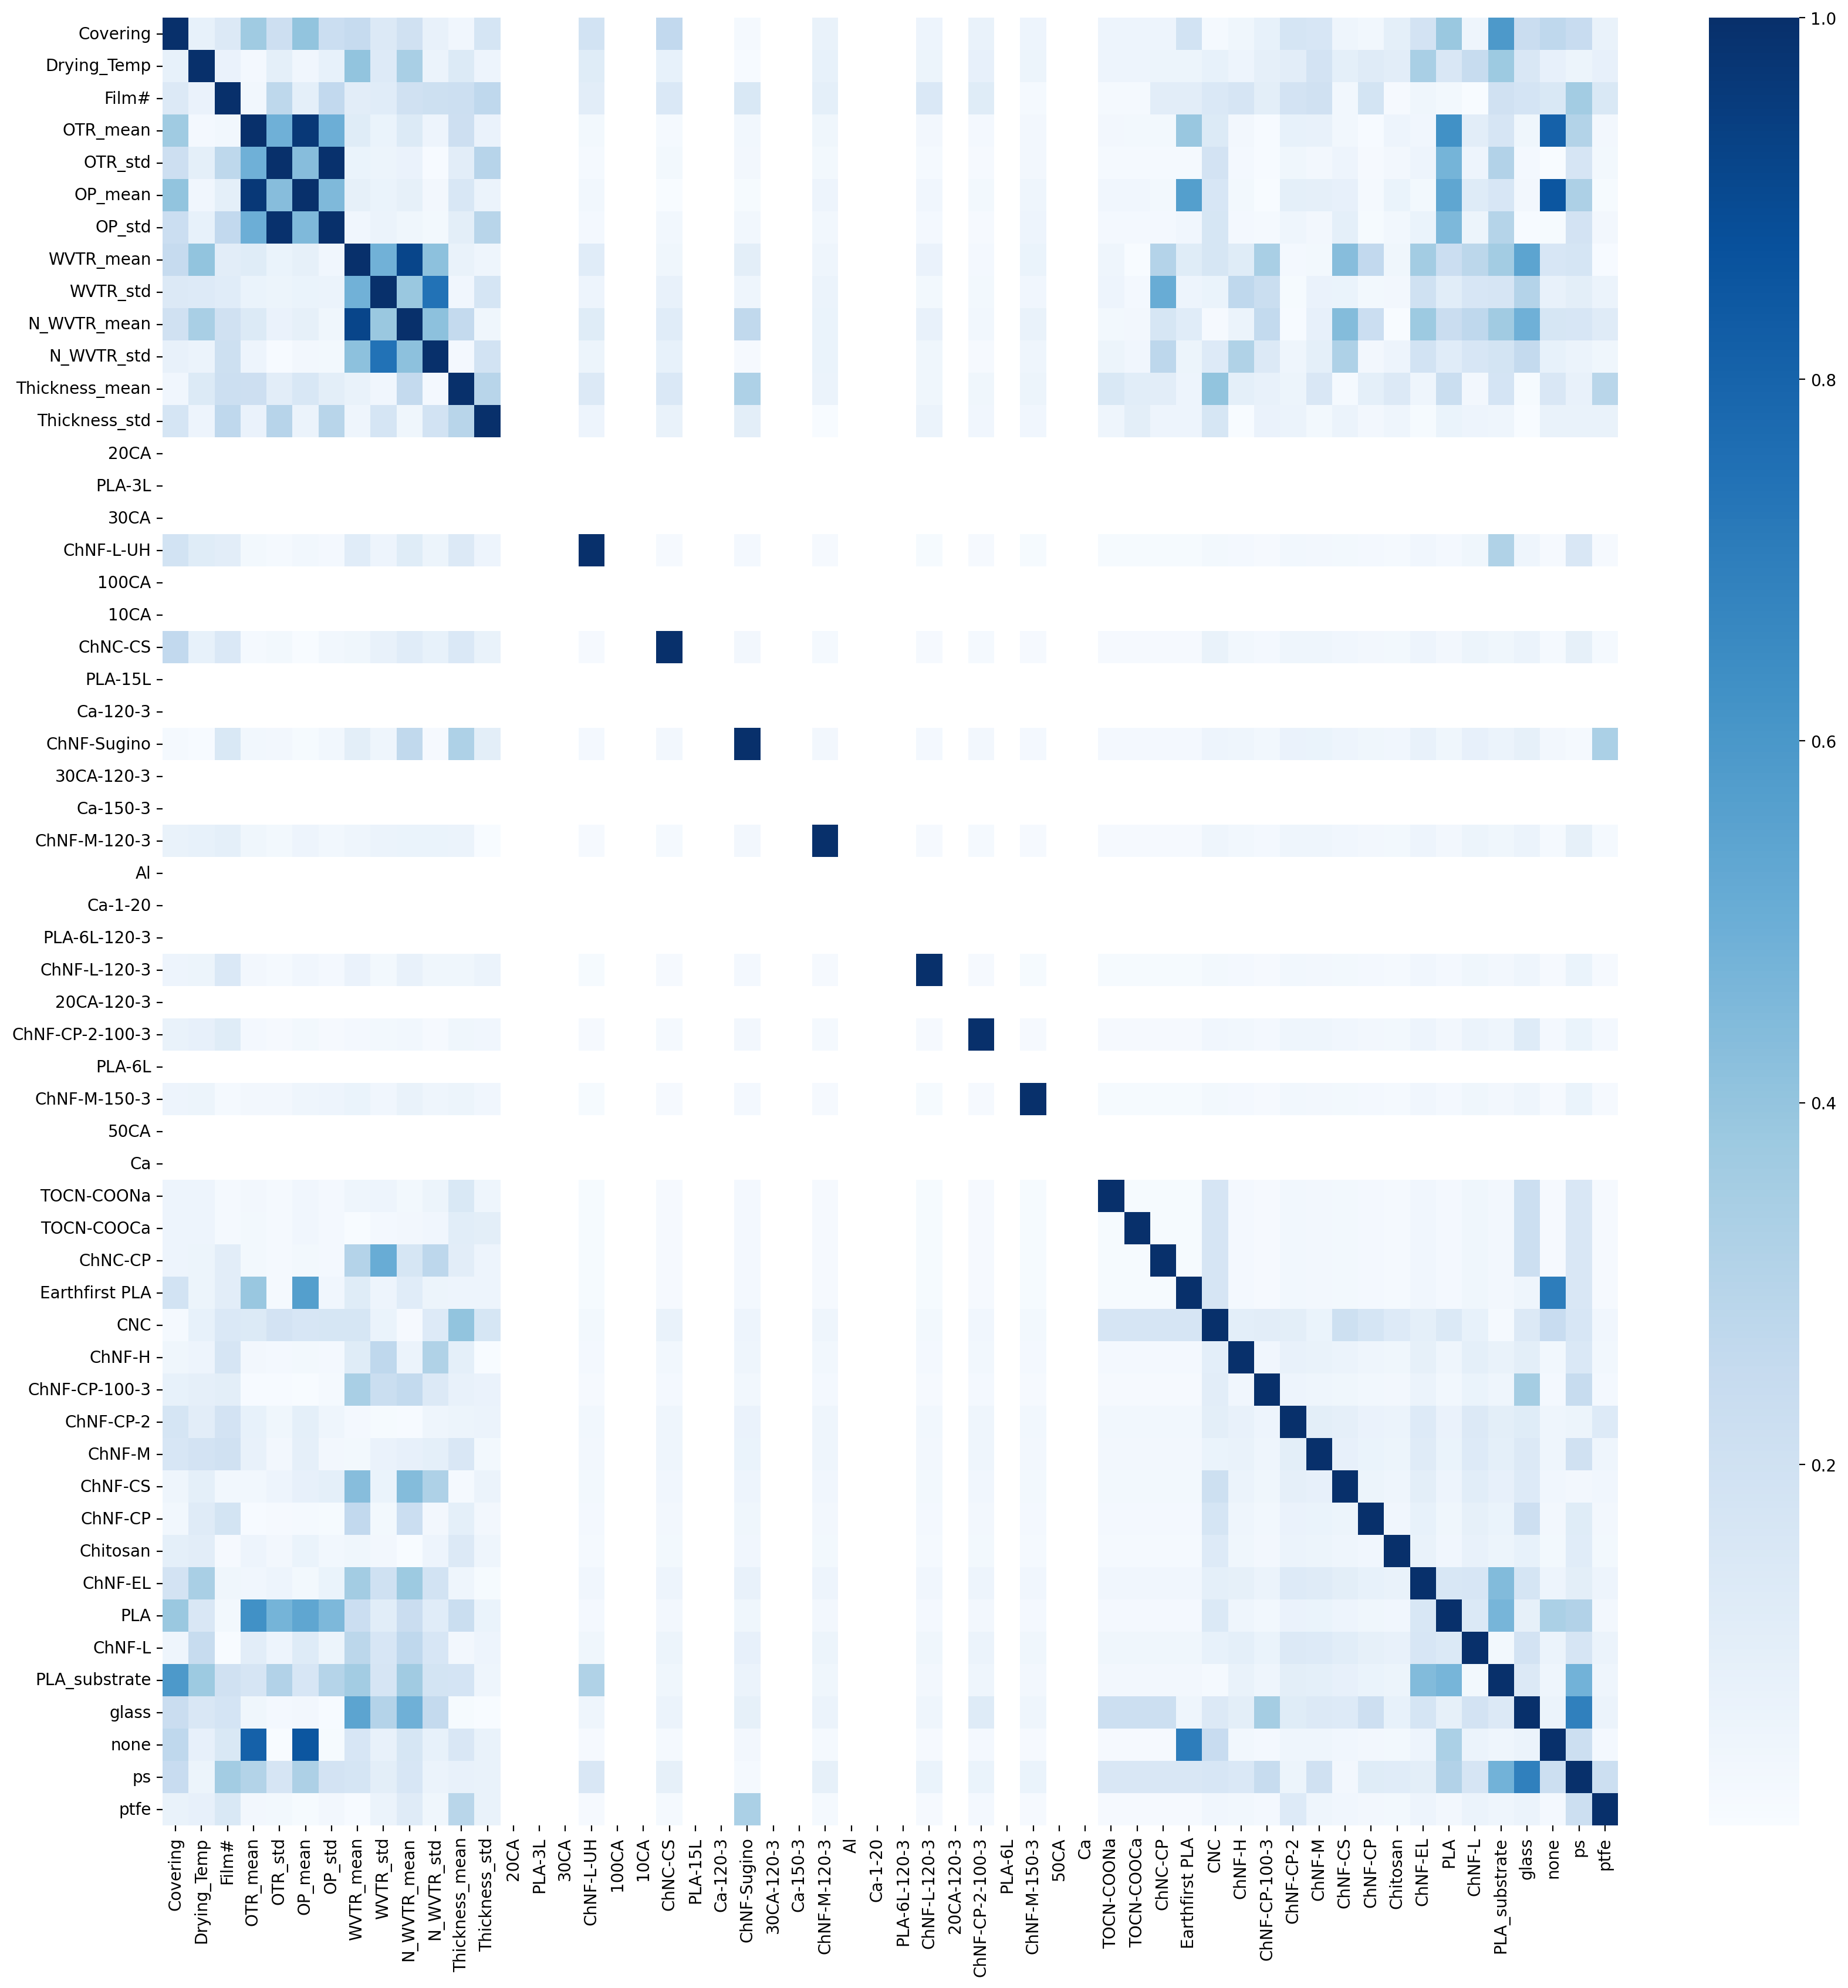

In [10]:
corr = df.corr().abs()
fig, ax = plt.subplots(figsize=(20,20),dpi=200)
sns.heatmap(corr,ax = ax, cmap='Blues', annot=False,)
fig.savefig('Correlation_Matrix_RH50.png')

- Histogram the input features

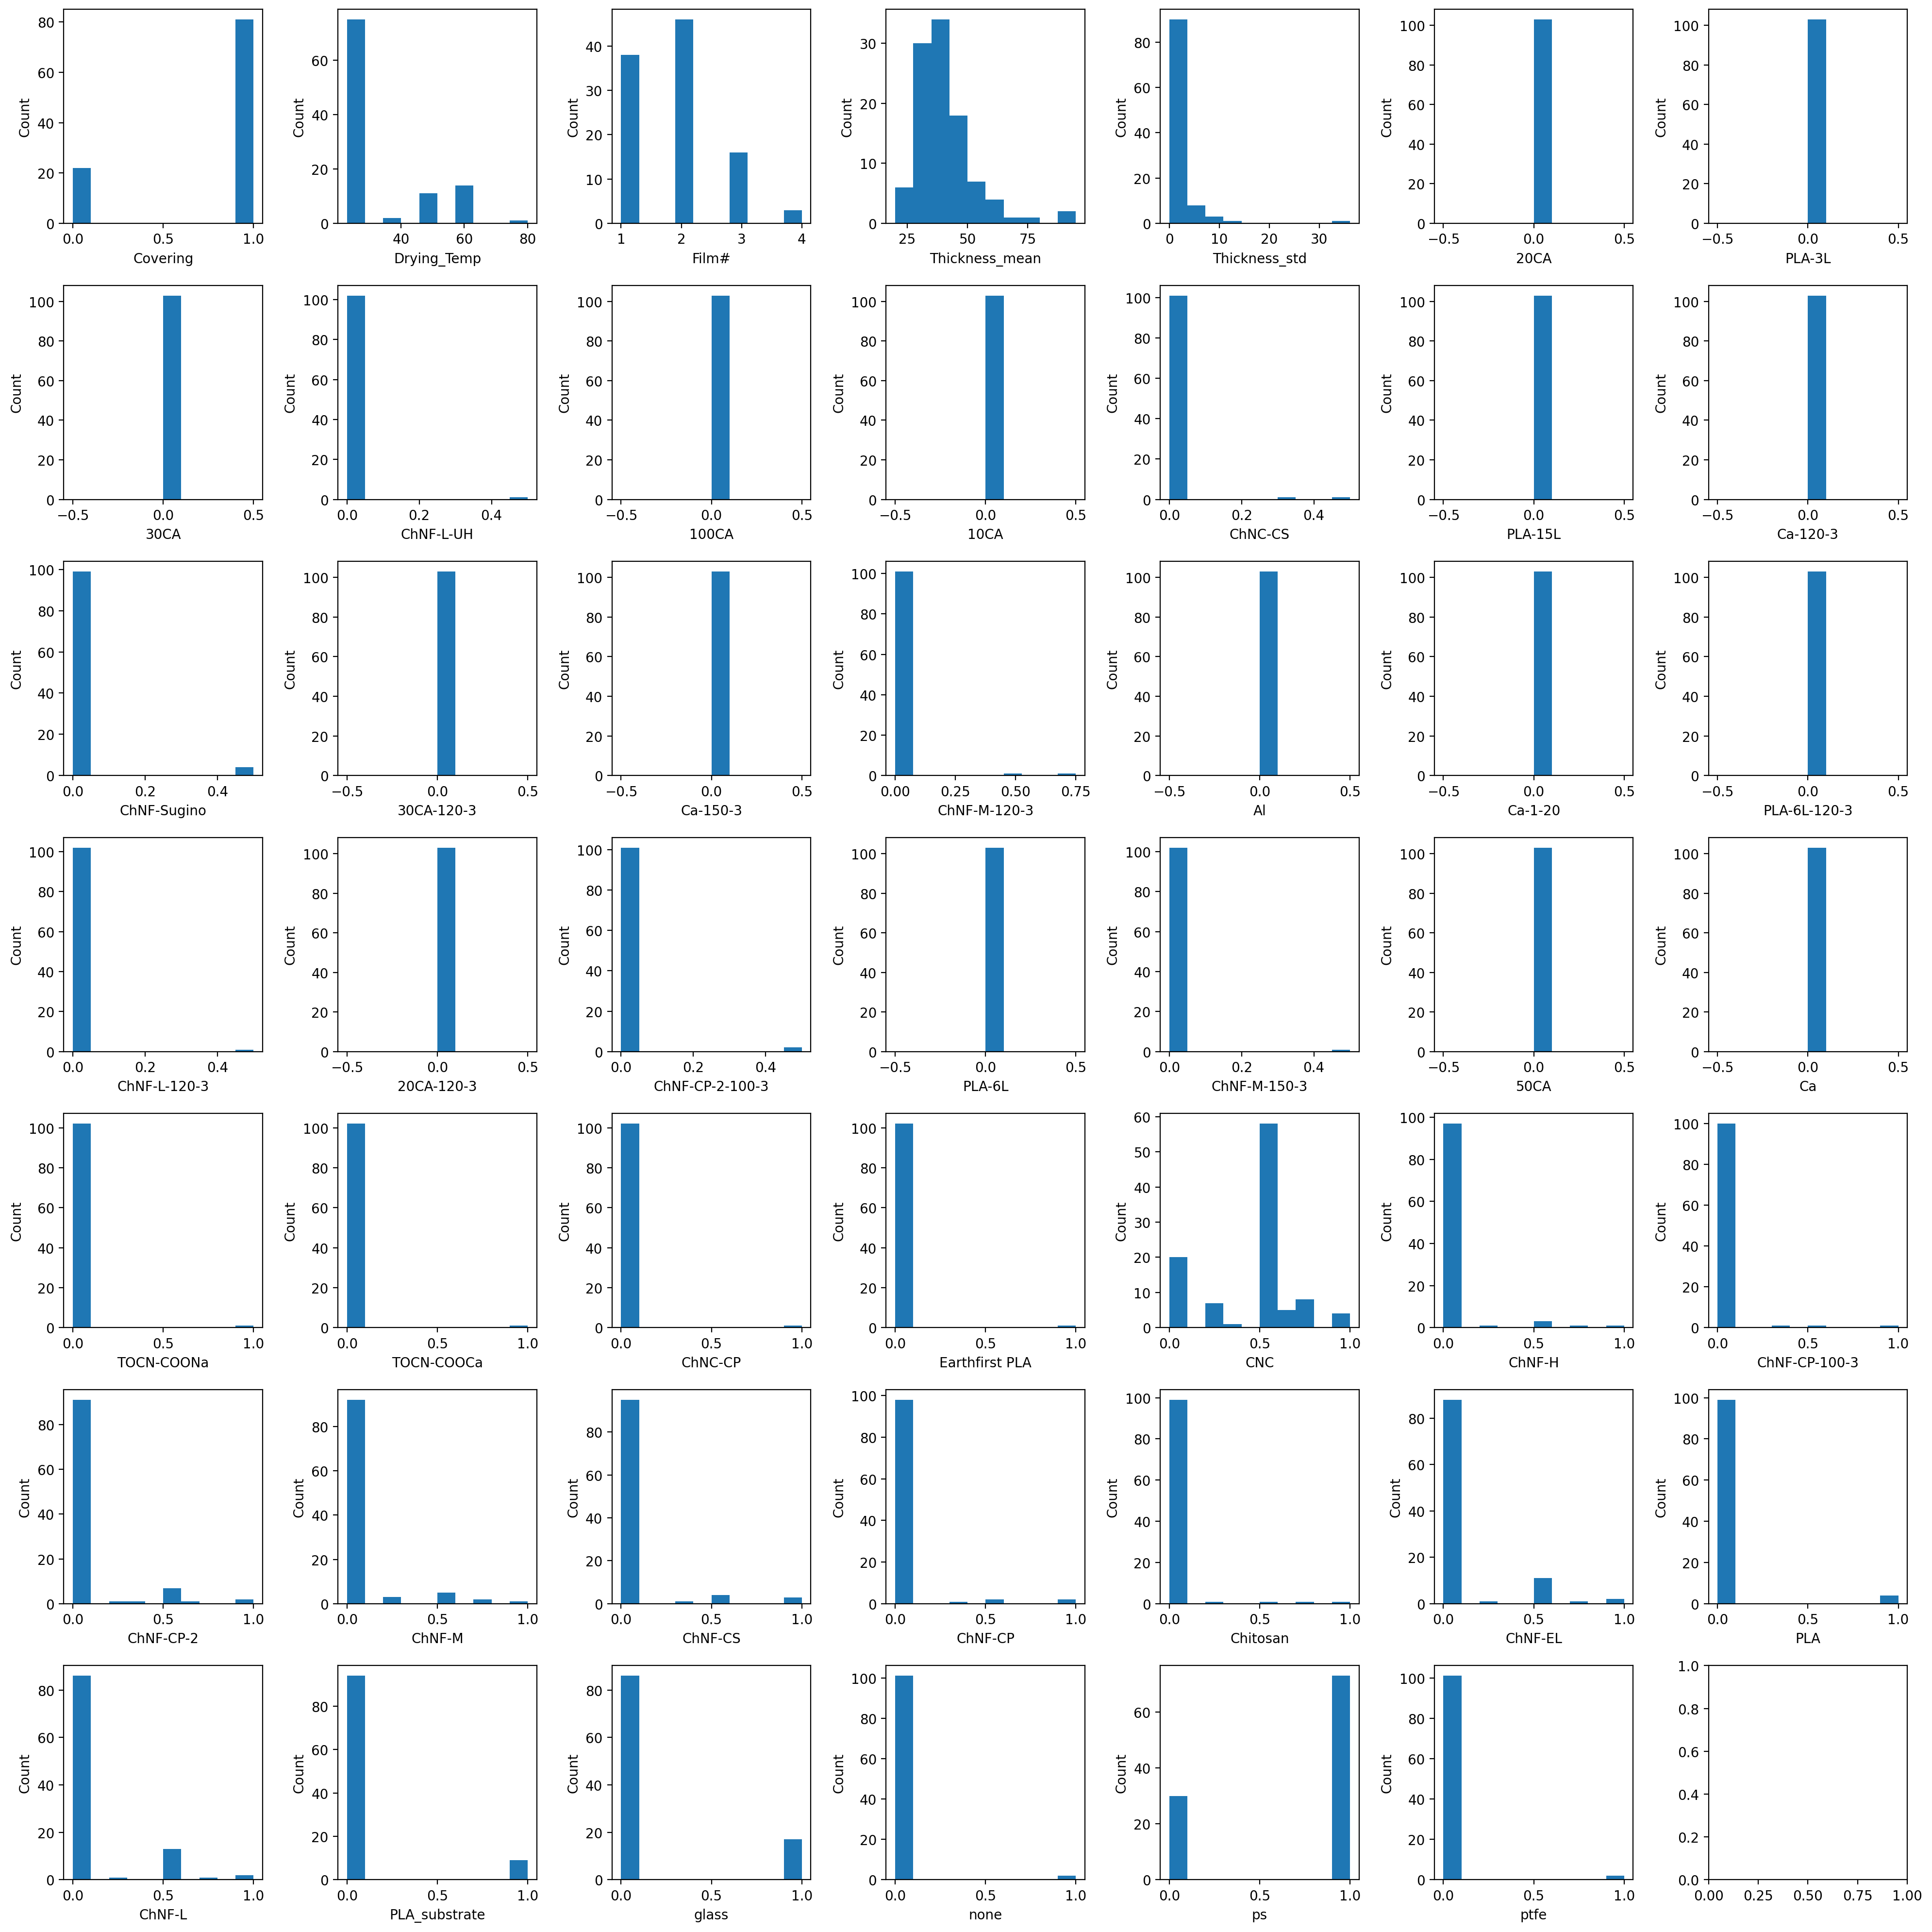

In [11]:
Targets = ['OTR_mean','OTR_std','OP_mean','OP_std','WVTR_mean','WVTR_std','N_WVTR_mean','N_WVTR_std']
Features = [i for i in df.columns if i not in Targets]
n_plots = len(Features)
n_axis = int(np.ceil(np.sqrt(n_plots)))
fig, ax = plt.subplots(n_axis,n_axis,figsize=(20,20),dpi=200)
for i in range(n_axis):
    for j in range(n_axis):
        if i*n_axis+j < n_plots:
            ax[i,j].hist(df[Features[i*n_axis+j]])
            ax[i,j].set_xlabel(Features[i*n_axis+j])
            ax[i,j].set_ylabel('Count')
plt.tight_layout()

In [12]:
fig.savefig('Feature_Distributions_RH50.png')

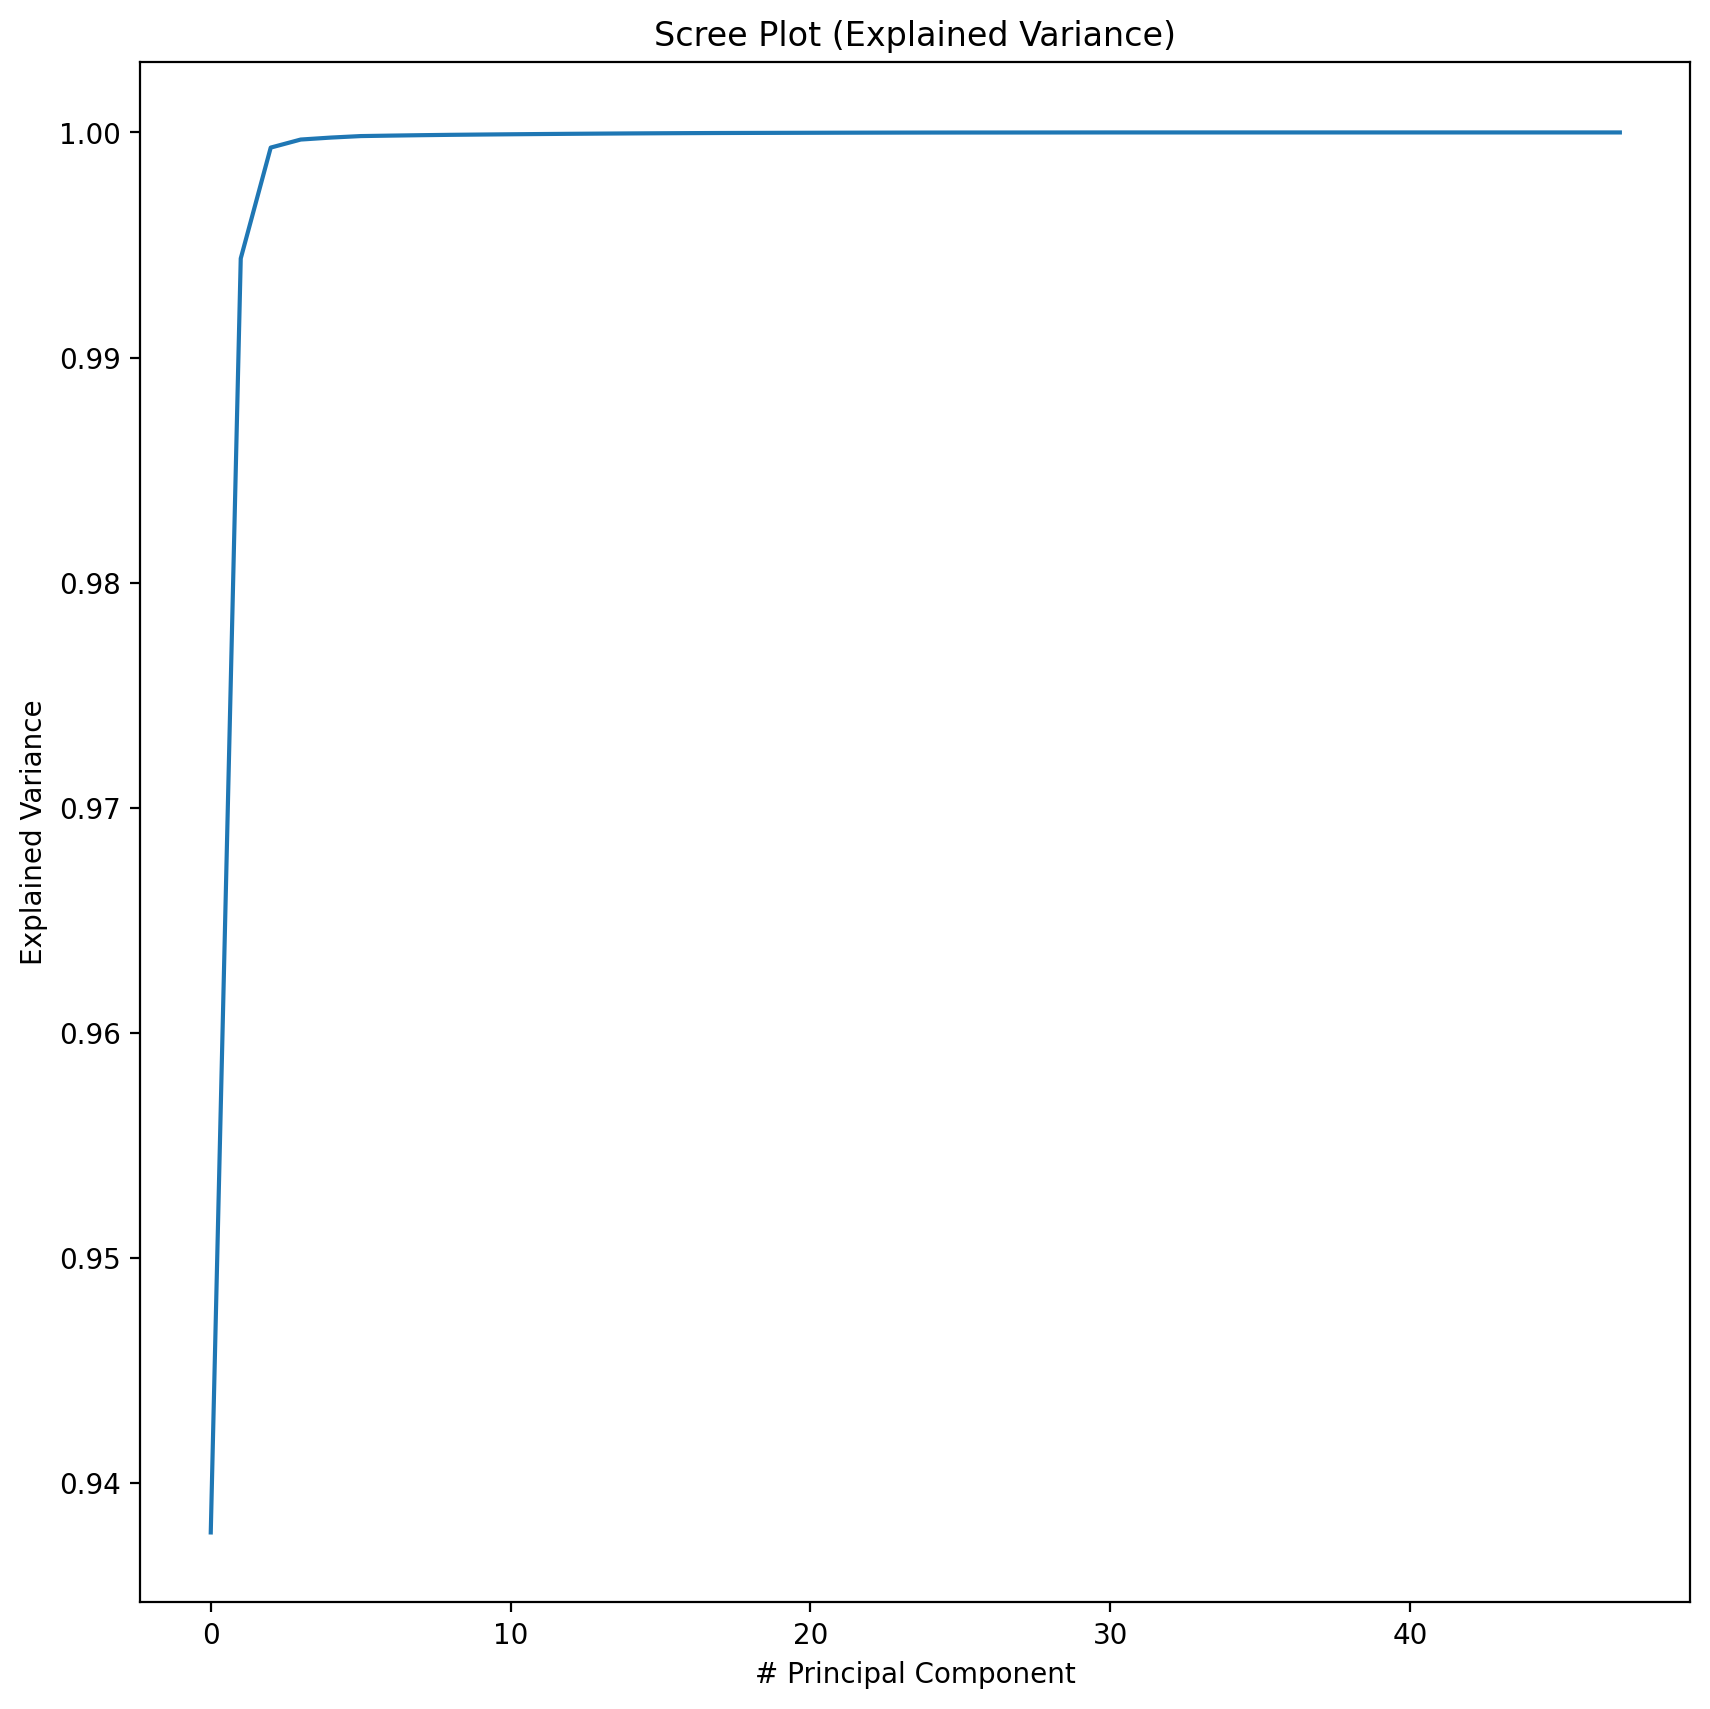

In [13]:
numeric_features = df[Features].to_numpy()
numeric_targets = df[Targets].to_numpy()

covariance_matrix = np.dot(numeric_features.T, numeric_features)
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
explained_variance = np.cumsum(eigenvalues/np.sum(eigenvalues))
fig, ax = plt.subplots(figsize=(10,10),dpi=200)
ax.plot(explained_variance)
ax.set_title('Scree Plot (Explained Variance)')
ax.set_xlabel('# Principal Component')
ax.set_ylabel('Explained Variance')
fig.savefig('Scree_Plot_RH50.png')

Text(0.06, 0.5, 'PC2')

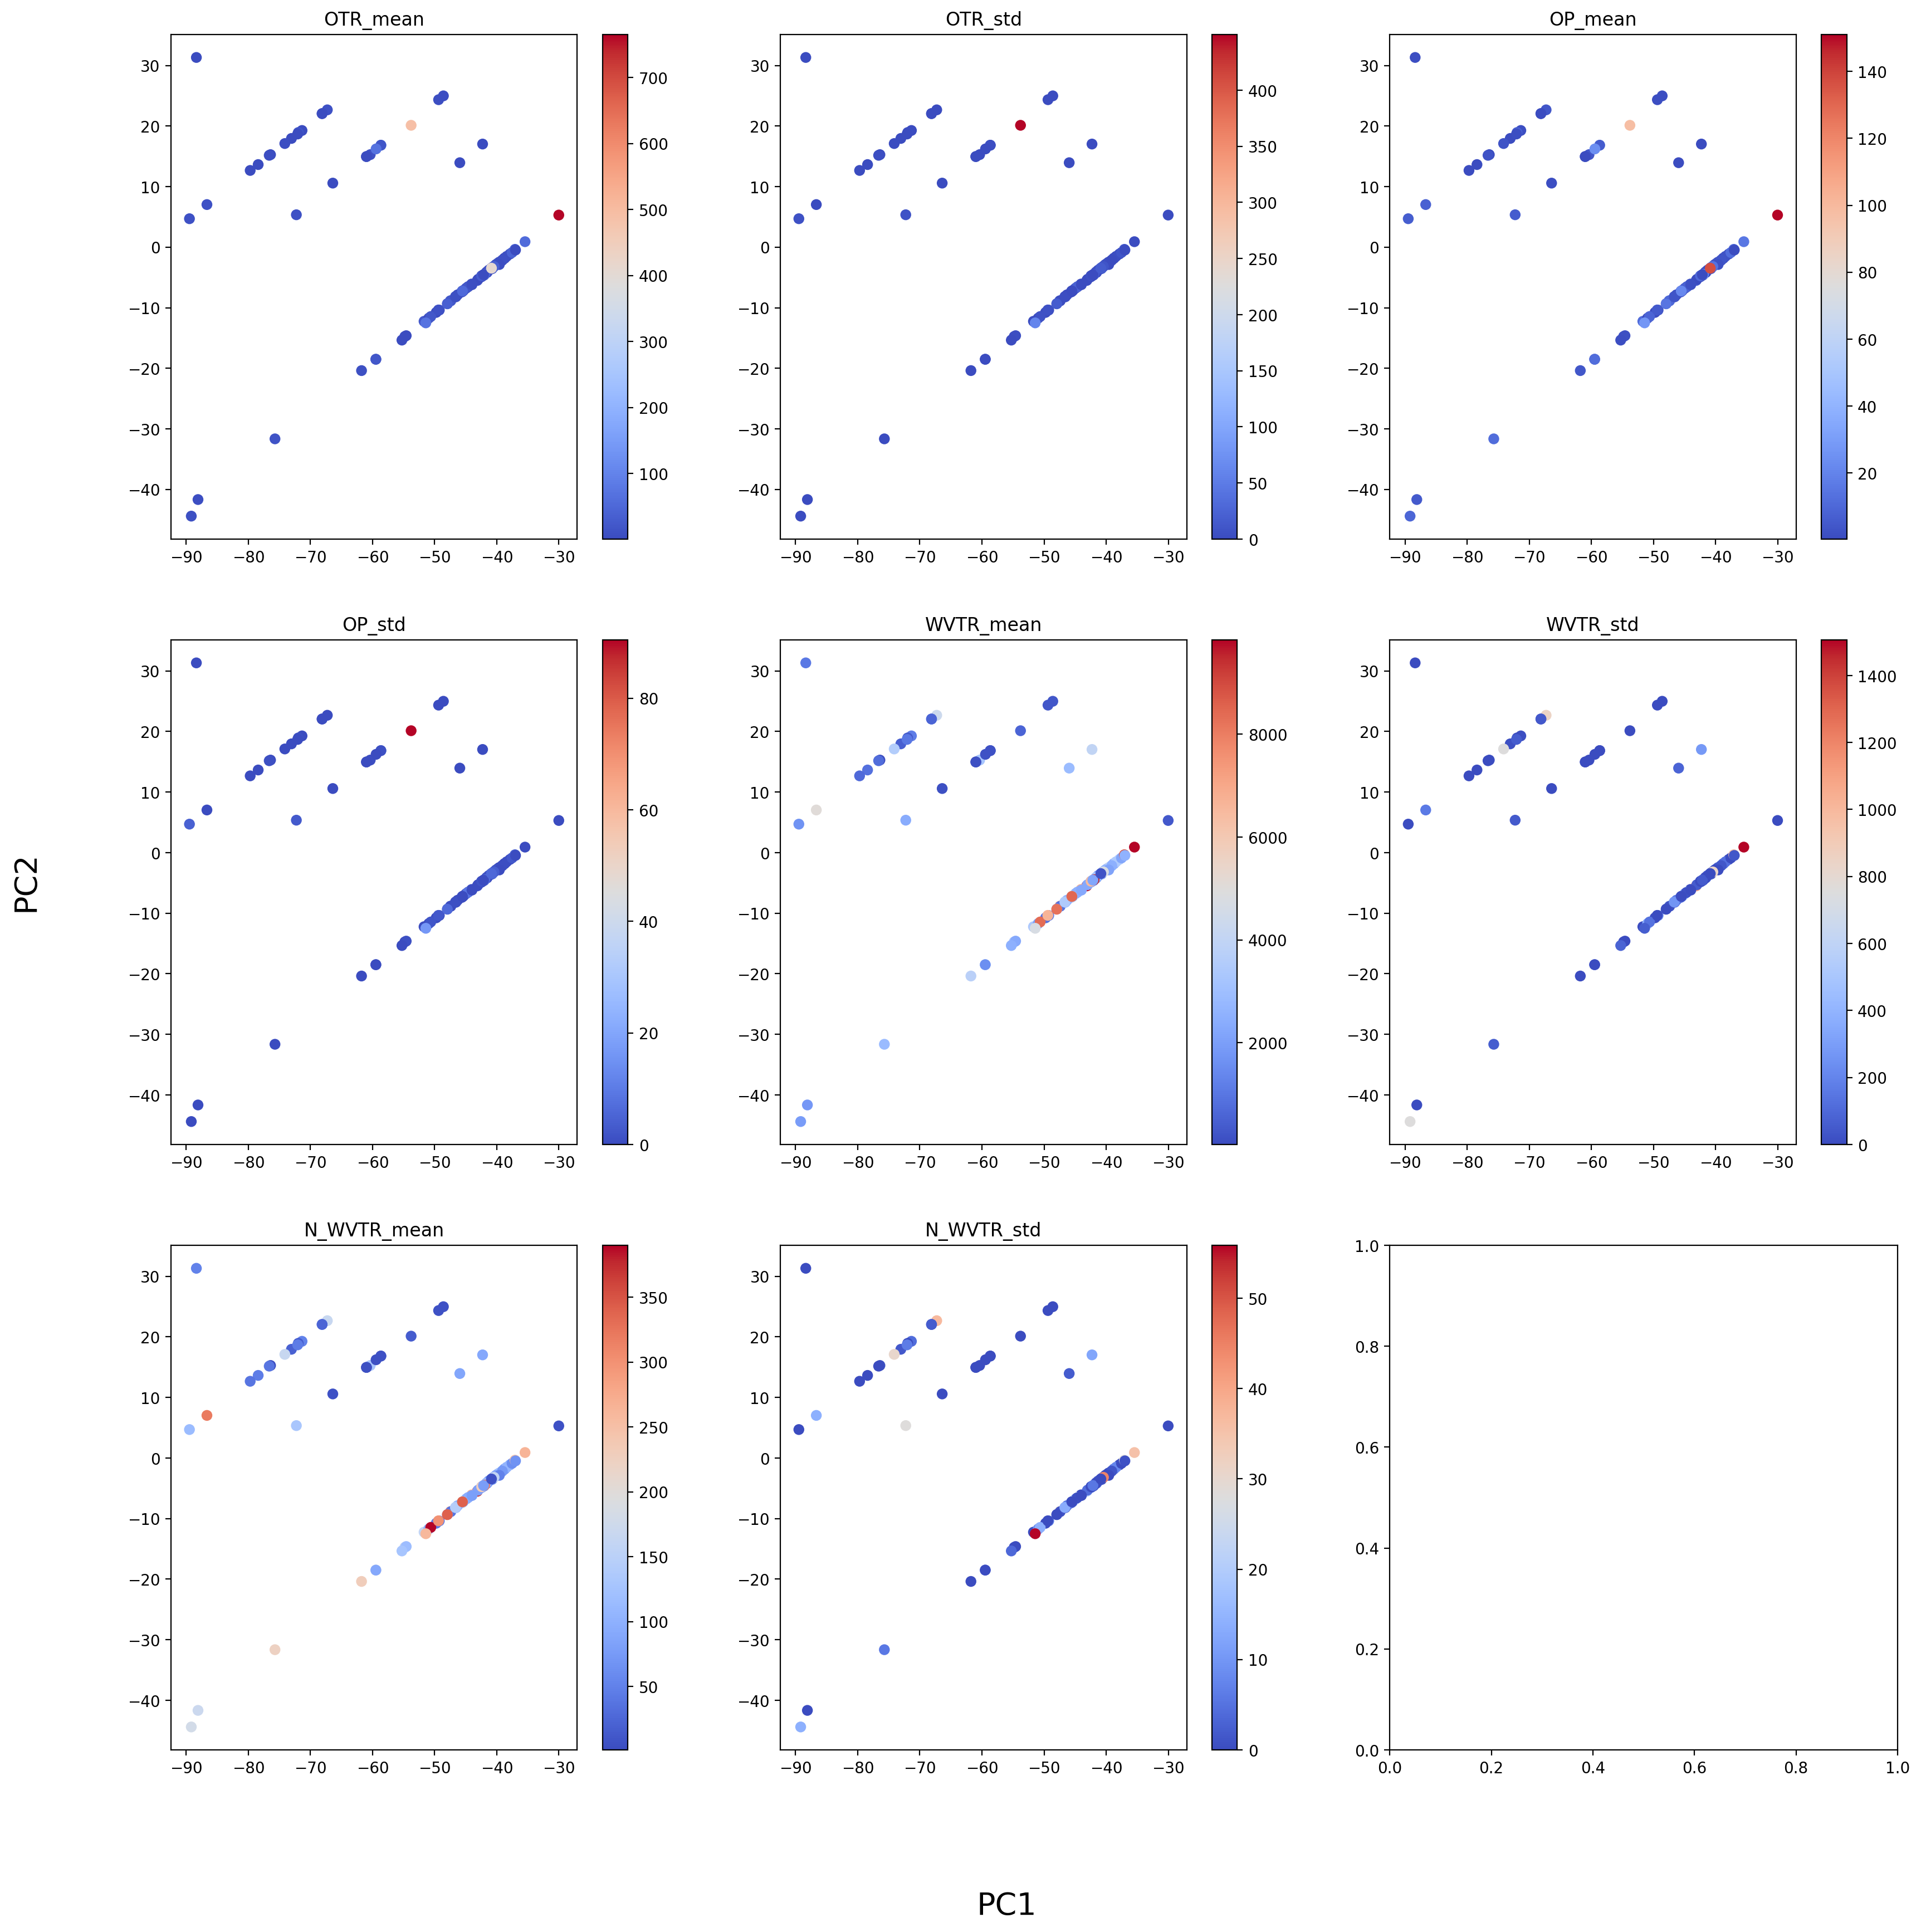

In [21]:
# PCA projection
PCA_comps = np.dot(numeric_features, eigenvectors[:,:2])

n_targets = len(Targets)
n_axis = int(np.ceil(np.sqrt(n_targets)))
fig, ax = plt.subplots(n_axis,n_axis,figsize=(20,20),dpi=200)
for i in range(n_axis):
    for j in range(n_axis):
        if i*n_axis+j < n_targets:
            im = ax[i,j].scatter(PCA_comps[:,0], PCA_comps[:,1], c=numeric_targets[:,i*n_axis+j], cmap='coolwarm')
            plt.colorbar(im, ax=ax[i,j])
            ax[i,j].set_title(Targets[i*n_axis+j])

fig.text(0.5, 0.04, 'PC1', ha='center', va='center', fontdict={'fontsize': 20})
fig.text(0.06, 0.5, 'PC2', ha='center', va='center', rotation='vertical',fontdict={'fontsize': 20})


In [15]:
fig.savefig('PCA_Projection_RH50.png')

## Linear Regression

In [16]:
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Using all features
all_features_mses = []
for col in df.columns:
    data = df.copy()
    y = data[f'{col}'].to_numpy()
    data = data.drop(columns=[f'{col}'])
    assert col not in data.columns.to_list()
    X = data.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    #print("R^2: ", model.score(X, y))
    y_pred = model.predict(np.array(X_test))
    mse = mean_squared_error(y_test, y_pred)
    all_features_mses.append(mse)

# Using pairs 
pairs_mses = []
pairs = itertools.permutations(df.columns.to_list(), 2)
for pair in pairs:
    x_col = pair[0]
    y_col = pair[1]
    data = df.copy()
    data = data[[f'{x_col}', f'{y_col}']]
    y = data[f'{y_col}'].to_numpy()
    data = data.drop(columns=[f'{y_col}'])
    assert y_col not in data.columns.to_list()
    X = data[f'{x_col}'].to_numpy().reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model = LinearRegression().fit(X_train, y_train)
    #print("R^2: ", model.score(X, y))
    y_pred = model.predict(np.array(X_test))
    mse = mean_squared_error(y_test, y_pred)
    pairs_mses.append(mse)

    

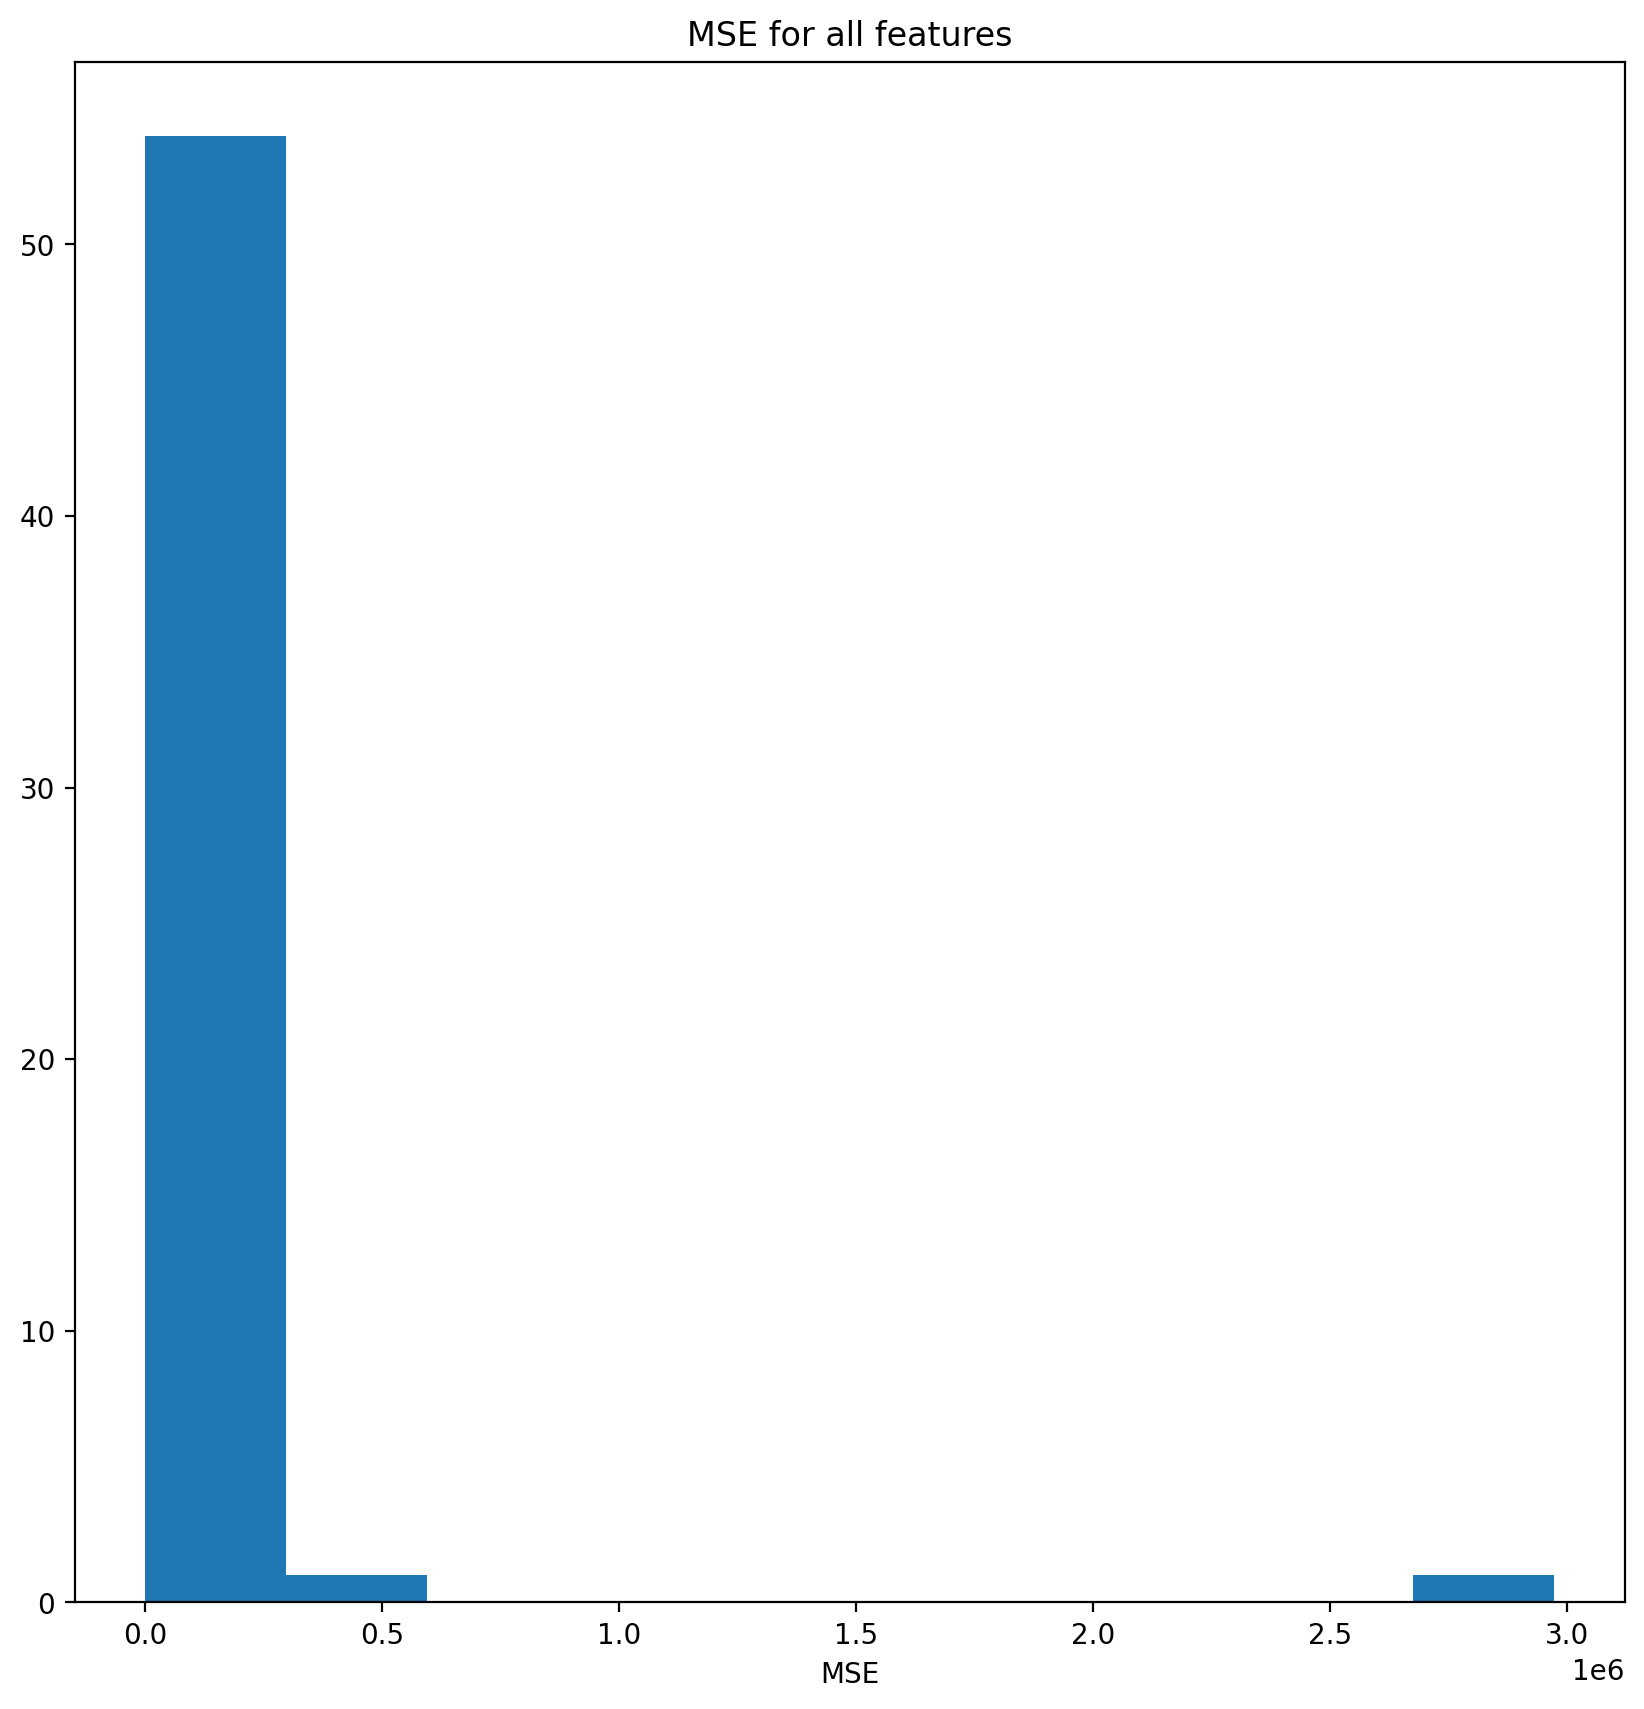

In [17]:
fig, ax = plt.subplots(figsize=(10,10),dpi=200)
ax.hist(all_features_mses, 10)
ax.set_title('MSE for all features')
ax.set_xlabel('MSE')
fig.savefig('MSE_All_Features_RH50.png')

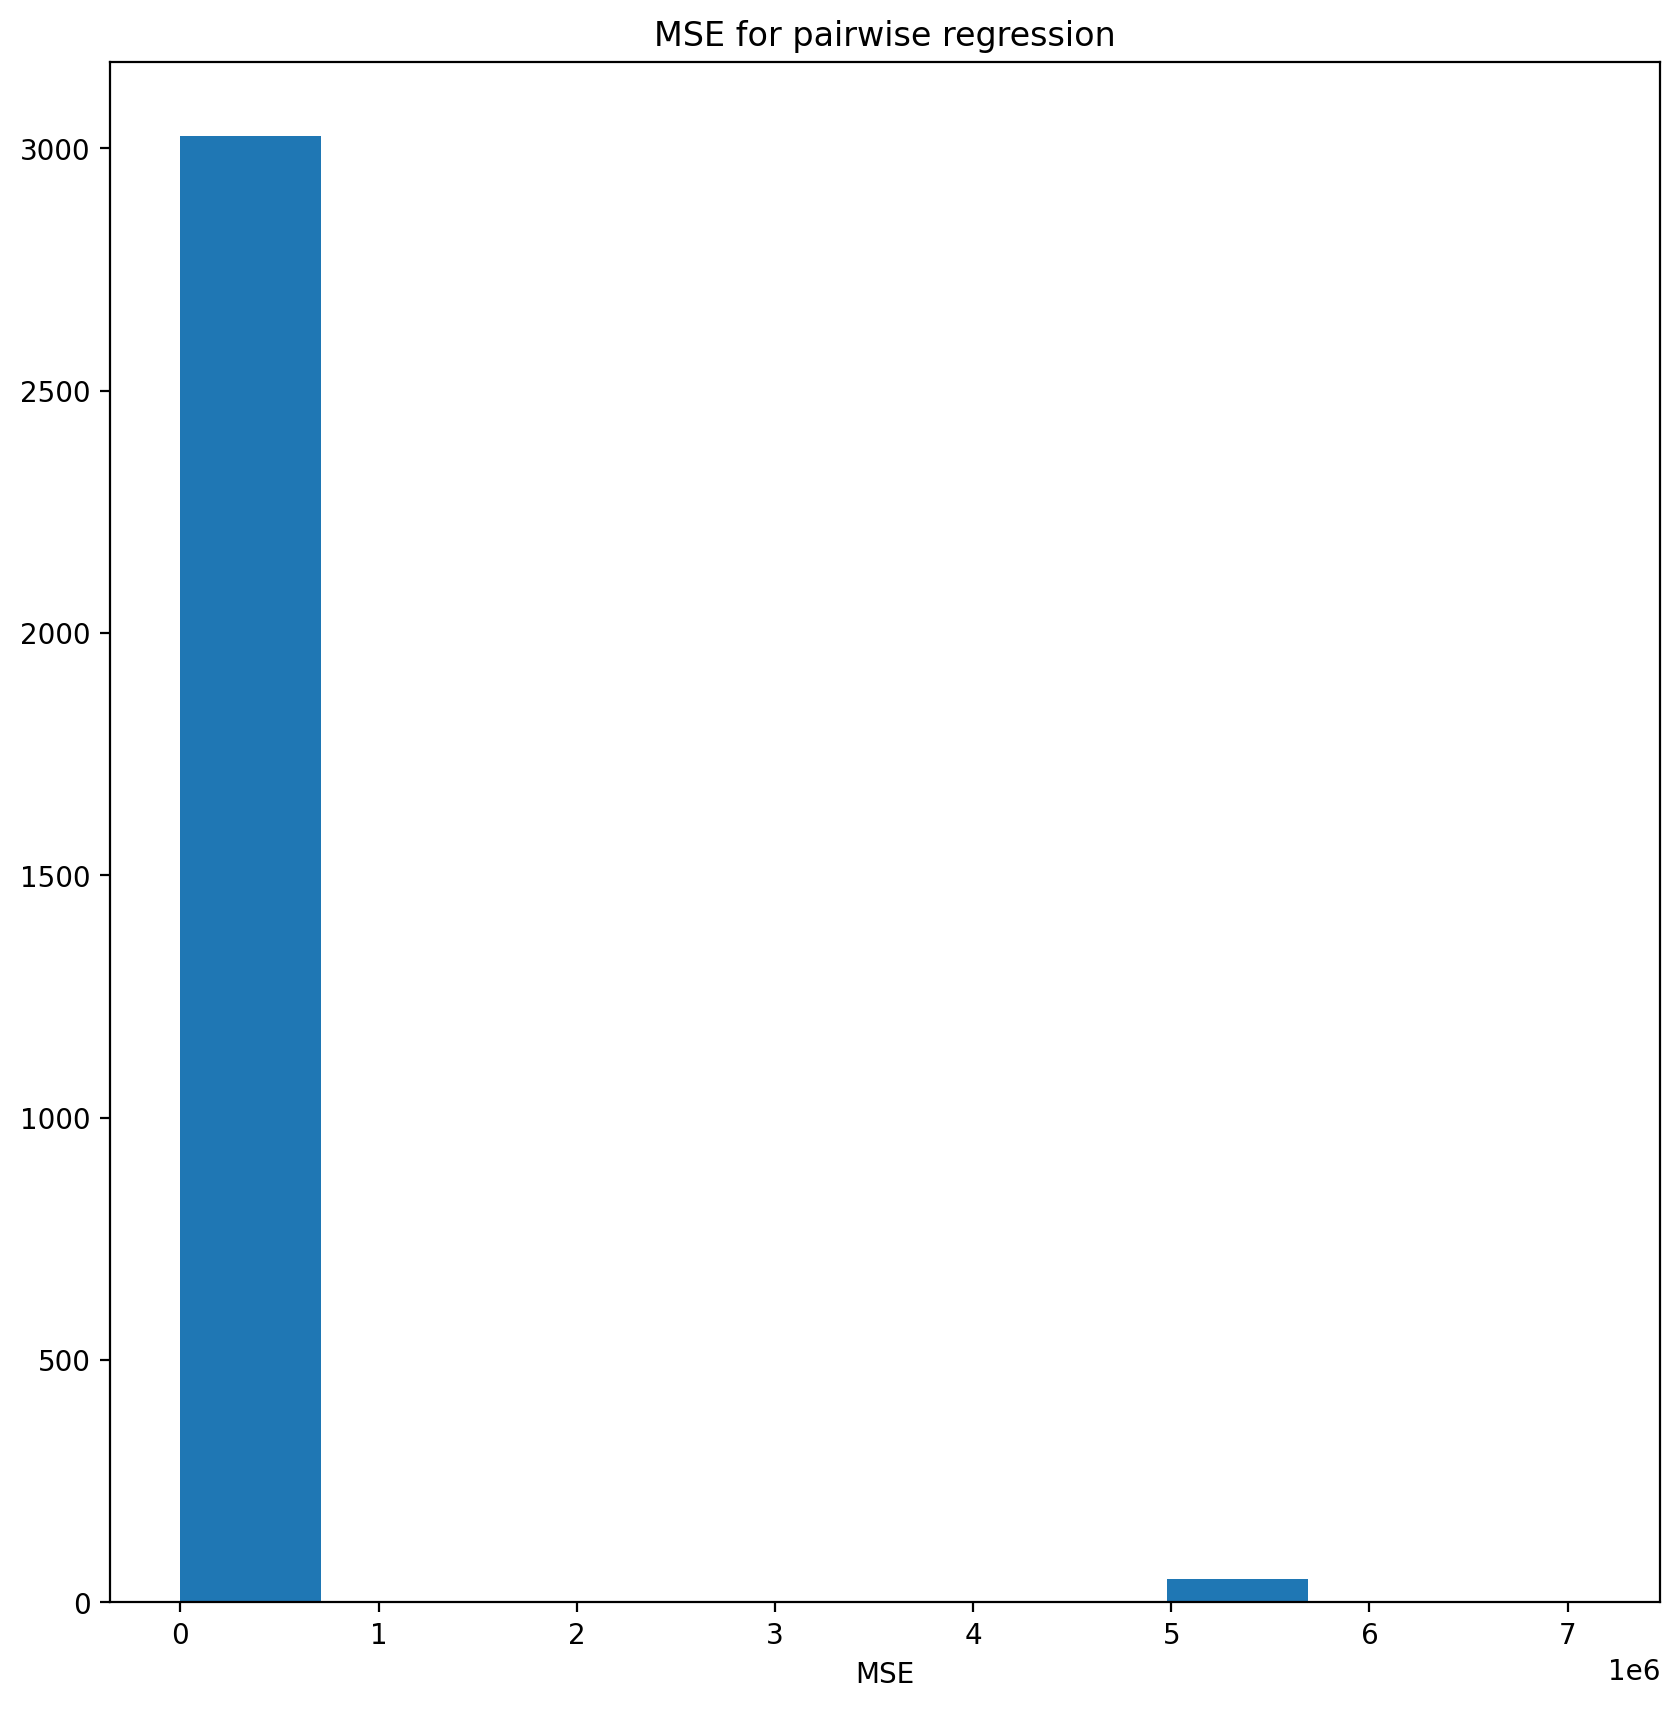

In [18]:
fig, ax = plt.subplots(figsize=(10,10),dpi=200)
ax.hist(pairs_mses, 10)
ax.set_title('MSE for pairwise regression')
ax.set_xlabel('MSE')
fig.savefig('MSE_Pairs_RH50.png')